In [202]:
import json
import pandas as pd
import MeCab
import matplotlib.pyplot as plt
import csv
import numpy as np
from wordcloud import WordCloud
from janome.analyzer import Analyzer
from janome.charfilter import UnicodeNormalizeCharFilter, RegexReplaceCharFilter
from janome.tokenizer import Tokenizer as JanomeTokenizer  # sumyのTokenizerと名前が被るため
from janome.tokenfilter import POSKeepFilter, ExtractAttributeFilter
import re
import ipadic
from tqdm import tqdm
import unicodedata
#Algos
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer

from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.reduction import ReductionSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.summarizers.kl import KLSummarizer
from janome.tokenizer import Tokenizer as JanomeTokenizer
from janome.analyzer import Analyzer
from janome.charfilter import *
from janome.tokenfilter import *
from sumy.utils import get_stop_words

import pkg_resources, imp
imp.reload(pkg_resources)
import unicodedata
import spacy
nlp = spacy.load('ja_ginza')#spacyの日本語モデル(Ginza)をロード

from ginza import *
import neologdn
import re
import emoji
import mojimoji
from collections import Counter



In [203]:
import sys
import pandas as pd
#
import sqlite3
# ------------------------------------------------------------------
sys.stderr.write("*** 開始 ***\n")
#読み込み先
file_company = "./datas/OpenWork_company.db"
file_company_info = './datas/OpenWork_company_info.db'

conn = sqlite3.connect(file_company)
conn2 = sqlite3.connect(file_company_info)
#
company_df=pd.read_sql_query('SELECT * FROM df_company', conn)
company_info_df=pd.read_sql_query('SELECT * FROM df_company_info', conn2)
display(company_df.head(15))
display(company_info_df.head(15))
#
conn.close()
conn2.close()
sys.stderr.write("*** 終了 ***\n")

#複数行に値が重複している可能性があるためdrop_duplicatesで、1行1ユニーク値にする
company_df = company_df.drop_duplicates()
company_info_df = company_info_df.drop_duplicates()

company_info_df.tail()

*** 開始 ***


,企業名,企業ID,口コミ種別ID,回答日時,評価,本文,業種,口コミ種別,職種,経験年数,現職/退職,新卒/中途,性別
0,株式会社極洋,a0910000000Fqdi,1,2021年09月16日,2.9,典型的な昔の会社。上の人間になればなるほど安定を好み、チャレンジ精神や新しい文化を取り入れる雰囲気がなく、そのしわ寄せに下の人間はよく働いている印象。平均年齢が比較的高い会社になるため、世代間ギャップが散見される。,食品、飲料,組織体制・企業文化,水産,営業,在籍3年未満,現職（回答時）,新卒入社
1,株式会社極洋,a0910000000Fqdi,1,2018年04月12日,3.8,一部上場企業なので土台はしっかりしている。歴史も80年以上あるので、それだけ続いてきた会社なので長所はたくさんある。ただ、歴史ある会社の裏返しとして古めかしい体質という印象もある。,食品、飲料,組織体制・企業文化,管理部門,在籍3～5年,退社済み(2015年より前),新卒入社,女性
2,株式会社極洋,a0910000000Fqdi,1,2017年05月17日,2.8,水産、加工食品、常温、鰹鮪の４事業が主力。本社、支社に分けられる。支社が販社、独立採算制。人数が少ない為、個人に与えられる裁量が大きい。個人の商売気質が高く、風通しが良い。,食品、飲料,組織体制・企業文化,営業,在籍10～15年,退社済み(2020年より前),新卒入社,男性
3,株式会社極洋,a0910000000Fqdi,1,2018年03月05日,3.3,良い意味では会社が古く、福利厚生・給与等安定している。また、基本的にクビにもならない。悪い意味では年功序列のため、結果を出しても出さなくても、評価は大きく変わらない。,食品、飲料,組織体制・企業文化,社員,在籍3～5年,現職（回答時）,新卒入社,男性
4,株式会社極洋,a0910000000Fqdi,1,2018年01月04日,2.6,古い会社なので年功序列、上の言うことは絶対の風潮があり、風通しは悪い。また年齢構成がいびつになっている層があり、仕事内容と収入のバランスは悪いと感じることがある。,食品、飲料,組織体制・企業文化,営業,在籍5～10年,現職（回答時）,新卒入社,男性
5,株式会社極洋,a0910000000Fqdi,1,2015年07月17日,3.3,水産気質というか、たくましい人が多い。上下関係は厳しかったが、根が優しい人が多かった印象。実力主義で比較的自由に行動することができたと思います。,食品、飲料,組織体制・企業文化,営業,在籍3～5年,退社済み(2015年より前),新卒入社,男性
6,日本水産株式会社,a0910000000Fqdk,1,2016年03月25日,2.0,終身雇用・年功序列・新卒偏重・男性社会などの昭和の遺産から脱却できていない。それらに当てはまらない社員もいるが、あくまで外様扱い。所属していた部署の社員は社内結婚の割合が非常に多く、社宅や寮に住んで休日も社員同士でリクリェーションに行くなど、身内意識が強く、外の世間を知らないと感じることが多かった。一方で事業部や部署単位で縦割りの組織体制で、組織としての一体感が薄く、社員育成・情報共有などに関して非常に効率の悪い環境だった。その点は社内でも問題視されていたが、なかなか改善が難しいようだ。,食品、飲料,組織体制・企業文化,事務,在籍5～10年,現職（回答時）,中途入社,女性
7,日本水産株式会社,a0910000000Fqdk,1,2017年04月12日,2.9,体育会系かと思います。お客様が第一、上司が第一。食品と水産とファイン事業があるので部署によりかなり雰囲気は異なります。少なくとも食品、水産は上記の雰囲気があるので女性としてながく働いていくことは考えづらいです。,食品、飲料,組織体制・企業文化,マーケティング,在籍5～10年,現職（回答時）,新卒入社,女性
8,日本水産株式会社,a0910000000Fqdk,1,2016年09月19日,2.4,社長が交代して変わった可能性があるが、「臭いものには蓋をする」という風土があったと思う。何か、問題が発生しても教訓として生かせていない。特に水産関係の部門は風通しが悪いという社内の評判を聞いたことがある。,食品、飲料,組織体制・企業文化,管理部門,在籍3～5年,退社済み(2015年より前),中途入社,女性
9,日本水産株式会社,a0910000000Fqdk,1,2016年03月03日,2.8,創業100年を超えている老舗企業であるので、組織体制及び企業文化については良くも悪くも老舗の日本的企業そのままであると思います。企業として、事業や商品などいろいろと新しいことに挑戦はしてみますが、大半は長続きせずいつの間にか元通りになっているようなイメージがあります。,食品、飲料,組織体制・企業文化,営業,在籍10～15年,退社済み(2015年より前),新卒入社,男性


,企業名,月残業時間,有給消化率,平均年収,設立年,総合スコア,社員の士気,風通し,社員相互尊重,20代成長性,長期育成,コンプラ,評価納得感,待遇満足度,業種
0,シークス,16.9,36.9,None,1937.0,3.00,3.3,2.9,2.4,3.1,2.5,3.2,3.2,3.5,食品、飲料
1,日本水産株式会社,31.1,59.0,None,1943.0,2.98,2.9,2.9,2.5,2.6,2.3,4.1,4.1,3.5,食品、飲料
2,マルハニチロ株式会社,16.2,49.3,530,1943.0,3.15,2.9,3.1,2.9,3.2,2.9,4.4,4.4,2.9,食品、飲料
3,株式会社ホウスイ,None,None,None,1945.0,2.93,2.9,2.9,2.9,3.0,2.8,2.9,2.9,3.2,食品、飲料
4,株式会社雪国まいたけ,14.3,46.6,None,2015.0,2.48,2.4,2.4,2.5,2.2,2.3,2.7,2.7,2.7,食品、飲料
5,カネコ種苗株式会社,20.2,20.0,None,1947.0,2.76,2.8,2.4,2.8,2.5,2.2,3.6,3.6,2.8,農業、林業、水産、畜産
6,株式会社サカタのタネ,10.7,54.8,None,1942.0,3.20,2.8,3.6,3.1,2.6,2.9,4.0,4.0,3.6,農業、林業、水産、畜産
7,ホクト株式会社（食品）,21.4,58.2,423,1964.0,2.85,3.0,2.7,3.4,2.6,2.6,3.2,3.2,2.7,食品、飲料
8,株式会社ホクリヨウ,29.0,37.0,None,1949.0,2.89,2.9,2.9,2.8,2.7,2.9,3.0,3.0,3.0,食品、飲料
9,株式会社ヒノキヤグループ,32.2,39.6,None,1988.0,2.89,2.9,3.0,2.9,2.9,2.9,3.0,3.0,2.7,不動産関連、住宅


*** 終了 ***


,企業名,月残業時間,有給消化率,平均年収,設立年,総合スコア,社員の士気,風通し,社員相互尊重,20代成長性,長期育成,コンプラ,評価納得感,待遇満足度,業種
2210,アマゾンジャパン合同会社,28.8,69.8,1004,2000.0,3.88,3.8,4.0,3.1,3.6,2.4,4.4,4.4,4.2,インターネット
2211,日本マイクロソフト株式会社,36.8,60.6,1290,1986.0,4.22,4.1,4.2,3.8,3.7,2.7,4.8,4.8,4.6,SIer、ソフト開発、システム運用
2212,アクセンチュア株式会社,39.0,66.2,854,1995.0,4.24,4.2,4.3,3.9,4.6,3.0,3.8,3.8,4.1,コンサルティング、シンクタンク
2213,日本アイ・ビー・エム株式会社（IBM）,38.9,49.8,915,1937.0,4.02,3.5,4.2,3.7,4.0,3.2,4.6,4.6,3.4,SIer、ソフト開発、システム運用
2214,株式会社セールスフォース・ジャパン（旧：株式会社セールスフォース・ドットコム）,39.3,58.9,1223,2000.0,4.65,4.6,4.5,4.1,4.6,3.8,4.6,4.6,4.6,SIer、ソフト開発、システム運用


In [204]:
import numpy as np
import pandas as pd

#company_dfの前処理
company_df.本文 = company_df.本文.str.replace('\u3000', ' ')
company_df.本文 = company_df.本文.str.replace('■', ' ')
company_df.本文 = company_df.本文.str.replace('⇒', ' ')
company_df.本文 = company_df.本文.str.replace('→', ' ')
company_df.本文 = company_df.本文.str.replace('□', ' ')
company_df.本文 = company_df.本文.str.replace('：', ' ')
company_df.本文 = company_df.本文.str.replace('▷', ' ')
#company_info_dfの前処理
def preprocessing(company_info_df):
        
    #まず、'--'が含まれている場合はNaNに置き換える
    replace_line = company_info_df.replace('--',None)

    #欠損していない値が3未満の企業はdrop
    processed_company_info_df = replace_line.dropna(axis=1, thresh=3,  inplace=False)

    #obj→floatに変換
    processed_company_info_df.月残業時間 = processed_company_info_df.月残業時間.astype('float')
    processed_company_info_df.有給消化率 = processed_company_info_df.有給消化率.astype('float')
    processed_company_info_df.平均年収  = processed_company_info_df.平均年収.astype('float')
    processed_company_info_df.総合スコア = processed_company_info_df.総合スコア.astype('float')
    processed_company_info_df.社員の士気 = processed_company_info_df.社員の士気.astype('float')
    processed_company_info_df.風通し = processed_company_info_df.風通し.astype('float')
    processed_company_info_df.社員相互尊重 = processed_company_info_df.社員相互尊重.astype('float')
    processed_company_info_df['20代成長性'] = processed_company_info_df['20代成長性'].astype('float')
    processed_company_info_df.長期育成 = processed_company_info_df.長期育成.astype('float')
    processed_company_info_df.コンプラ = processed_company_info_df.コンプラ.astype('float')
    processed_company_info_df.評価納得感 = processed_company_info_df.評価納得感.astype('float')
    processed_company_info_df.待遇満足度 = processed_company_info_df.待遇満足度.astype('float')
    
    #Nullは中央値で埋める
    processed_company_info_df = processed_company_info_df.fillna(value=processed_company_info_df.median())
    
    #その他、分析に必要なdfの必要な前処理
    processed_company_info_df['会社年齢'] = 2022 - processed_company_info_df['設立年']
    processed_company_info_df.drop('設立年',axis=1,inplace=True)
    
    return processed_company_info_df

company_info_df_processed = preprocessing(company_info_df)

In [205]:
#stopword list 
stopword_list = []
with open('./stopwords/stopwords.csv','r',encoding='utf-8') as f:
    text = f.readlines()
    for tk in text:
        tk = tk.strip('\n')
        tk = tk.replace('\ufeff','')
        stopword_list.append(tk)


東急建設株式会社

該当企業の分野別評価



,企業名,月残業時間,有給消化率,平均年収,総合スコア,社員の士気,風通し,社員相互尊重,20代成長性,長期育成,コンプラ,評価納得感,待遇満足度,会社年齢
30,東急建設株式会社,57.8,44.1,647.0,3.33,3.1,3.6,3.1,3.0,3.0,4.1,4.1,3.1,19.0


該当企業の業種平均評価



,月残業時間,有給消化率,平均年収,総合スコア,社員の士気,風通し,社員相互尊重,20代成長性,長期育成,コンプラ,評価納得感,待遇満足度,会社年齢
業種,,,,,,,,,,,,,
建築、土木、設備工事,45.99,41.28,565.76,3.16,3.1,3.13,3.08,3.14,2.84,3.43,3.43,3.1,65.65


------------------------
しかし、実際現場においては勤務時間が変えられていないというのが現状です。残業代はつくことにはつくのですが、決められた時間までしか付けることは出来ず、実際は出務表に付ける残業時間の1.52倍の時間は働いています。大手電鉄会社系列の建設会社なので、資本力もあり業績も安定しています。東急グループの建設会社で、東急沿線の街づくりに深く関わって成長してきた会社です。現在、渋谷再開発事業等の大型プロジェクトが進行しており、業績面でも安定してきていることから、将来の成長に向けた取組み検討を加速しており積極的な勢いを感じます。


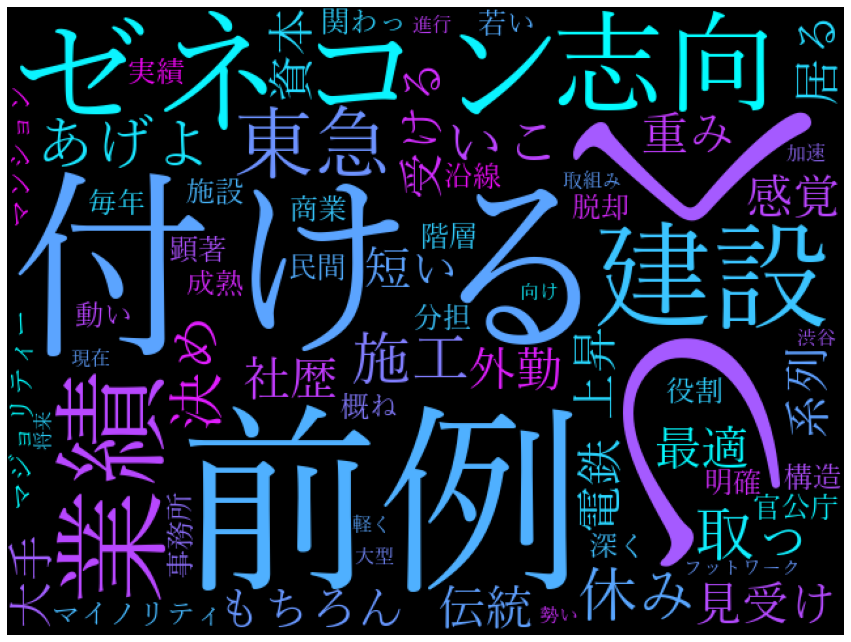

In [330]:
#指定した企業IDの企業コメントを可視化し、要約する関数

#企業ID指定
company_name = '東急建設株式会社'

#algos

algorithm_dic = {"lex": LexRankSummarizer(), "tex": TextRankSummarizer(), "lsa": LsaSummarizer(),\
                 "kl": KLSummarizer(), "luhn": LuhnSummarizer(), "redu": ReductionSummarizer(),\
                 "sum": SumBasicSummarizer()}

#日本語処理用のクラス
class JapaneseCorpus:
    # ①
    def __init__(self):
        self.nlp = spacy.load('ja_ginza')
        self.analyzer = Analyzer(
            char_filters=[UnicodeNormalizeCharFilter(), RegexReplaceCharFilter(r'[(\)「」、。]', ' ')],  # ()「」、。は全てスペースに置き換える
            tokenizer=JanomeTokenizer(),
            token_filters=[POSKeepFilter(['名詞', '形容詞', '副詞', '動詞']), ExtractAttributeFilter('base_form')]  # 名詞・形容詞・副詞・動詞の原型のみ
        )

    # ②
    def preprocessing(self, text):#前処理の関数
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\r', '', text)
        #text = re.sub(r'\d', '', text)
        text = re.sub(r'\s', '', text)
        text.replace('\u3000', '')
        text = text.lower()
        text = mojimoji.zen_to_han(text, kana=True)
        text = mojimoji.han_to_zen(text, digit=False, ascii=False)
        text = ''.join(c for c in text if c not in emoji.UNICODE_EMOJI)
        text = neologdn.normalize(text)

        return text

    # ③
    def make_sentence_list(self, sentences):
        doc = self.nlp(sentences)
        self.ginza_sents_object = doc.sents #与えられた文字列を文章単位に分割
        sentence_list = [s for s in doc.sents]

        return sentence_list

    # ④
    def make_corpus(self):
        corpus = [' '.join(self.analyzer.analyze(str(s))) + '。' for s in self.ginza_sents_object]

        return corpus


#WordCloudで可視化と、レビューの要約双方を行うクラス
class company_summarize:
    def __init__(self,company_name):
        self.company_name = company_name
        self.company_id = company_df[company_df.企業名 == company_name].企業ID.unique()[0]#compane_nameをIDに変換
        self.nlp = spacy.load('ja_ginza')
        self.analyzer = Analyzer(
            char_filters=[UnicodeNormalizeCharFilter(), RegexReplaceCharFilter(r'[(\)「」、。]', ' ')],  # ()「」、。は全てスペースに置き換える
            tokenizer=JanomeTokenizer(),
            token_filters=[POSKeepFilter(['名詞', '形容詞', '副詞', '動詞']), ExtractAttributeFilter('base_form')]  # 名詞・形容詞・副詞・動詞の原型のみ
        )

    
    #Wordcloudでの可視化
    def visualize(self):
        CHASEN_ARGS = r' -F "%m\t%f[7]\t%f[6]\t%F-[0,1,2,3]\t%f[4]\t%f[5]\n"'
        CHASEN_ARGS += r' -U "%m\t%m\t%m\t%F-[0,1,2,3]\t\t\n"'
        tagger = MeCab.Tagger(ipadic.MECAB_ARGS + CHASEN_ARGS)
        #null parse
        tagger.parse('')
    
        #指定した企業IDのみに絞る
        company_text = pd.DataFrame(company_df[company_df.企業名 == self.company_name])

        #dfの本文から口コミデータを抽出し、strで連結しテキストデータへ
        all_text = company_text.本文.str.cat()
    
        #正規化
        all_text_norm = unicodedata.normalize("NFKC", all_text)
    
        #parse
        node = tagger.parseToNode(all_text_norm)

        # 指定した品詞を抽出しリストに
        word_list = []
    
        while node:
            word_type = node.feature.split(',')[0]
            if word_type in ["名詞", "動詞", "形容詞",'副詞']:
                word_list.append(node.surface)
            #ここのインデントミスると無限ループ
            node = node.next

        # リストを文字列に変換
        word_chain = ' '.join(word_list)
    
        #ストップワードリストをコピー
        stopword_list_indef = stopword_list
        
        #word_listの要素数の10%は、最も登場頻度が高いワードなのでストップリストに追加する
        fdist = Counter(word_list)
        Common_Words = fdist.most_common(n=int(len(fdist)*0.10))
        
        for common_word in Common_Words:
            stopword_list_indef.append(common_word[0])

        #社名が入らないように、stopwordlistに追加
        stopword_list_indef.append(company_text.企業名.drop_duplicates().str.cat().replace('株式会社',''))

        # ワードクラウド作成
        W = WordCloud(width=640, height=480, background_color='black', colormap='cool_r',
                      font_path='C:\Windows\Fonts\yumin.ttf', stopwords = set(stopword_list_indef)).generate(word_chain)
        # 表示設定
        plt.figure(figsize = (15, 12))
        plt.axis('off')

        plt.imshow(W)
        
    #前処理、コーパスリスト作成など
    def preprocessing(self, text):
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\r', '', text)
        #text = re.sub(r'\d', '', text)
        text = re.sub(r'\s', '', text)
        text.replace('\u3000', '')
        text = text.lower()
        text = mojimoji.zen_to_han(text, kana=True)
        text = mojimoji.han_to_zen(text, digit=False, ascii=False)
        text = ''.join(c for c in text if c not in emoji.UNICODE_EMOJI)
        text = neologdn.normalize(text)

        return text

    def make_sentence_list(self, sentences):
        doc = self.nlp(sentences)
        self.ginza_sents_object = doc.sents
        sentence_list = [s for s in doc.sents]

        return sentence_list

    def make_corpus(self):
        corpus = [' '.join(self.analyzer.analyze(str(s))) + '。' for s in self.ginza_sents_object]

        return corpus
    
    #文章内容要約
    def summarize_sentences(self,sentences_count=10, algorithm="luhn", language="japanese"):
        
        company_split_df = pd.DataFrame(company_df[company_df.企業名 == self.company_name])
        if company_split_df.shape[0] >= 55:
            company_split_df = company_split_df.sample(n=55)
        #任意の企業名のレビューstrを取り出す
        all_text = company_split_df.本文.str.cat()
        all_text_norm = unicodedata.normalize("NFKC", all_text)
        sentences=' '.join(all_text_norm)
        
        #JPコーパスクラス継承
        corpus_maker = JapaneseCorpus()
        preprocessed_sentences = corpus_maker.preprocessing(sentences)
        preprocessed_sentence_list = corpus_maker.make_sentence_list(preprocessed_sentences)
        corpus = corpus_maker.make_corpus()
        parser = PlaintextParser.from_string(" ".join(corpus), Tokenizer(language))

        try:
            summarizer = algorithm_dic[algorithm]
        except KeyError:
            print("algorithm name:'{}'is not found.".format(algorithm))

        summarizer.stop_words = get_stop_words(language)
        #sentences_countは文書に一定の割合をかけた値でもよいが、読みやすさ重視で10センテンス固定長とする
        #int(len(corpus)*0.1)
        summary = summarizer(document=parser.document, sentences_count=sentences_count)
        
        
        if language == "japanese":
            return str("".join([str(preprocessed_sentence_list[corpus.index(sentence.__str__())]) for sentence in summary]))
        else:
            return str("".join([sentence.__str__() for sentence in summary]))

#run
if __name__ == '__main__':
    C = company_summarize(company_name)
    
    #結果の表示
    print('\033[1m' + C.company_name + '\033[0m'+ '\n')
    #company_info_dfから該当企業のスコアを表示
    print('\033[1m' + '該当企業の分野別評価' + '\033[0m'+ '\n')
    display(company_info_df_processed[company_info_df_processed.企業名 == company_name].drop('業種',axis=1))
    #該当企業の業種の平均スコアを表示
    print('\033[1m' + '該当企業の業種平均評価' + '\033[0m' + '\n')
    
    #業種平均を表示
    company_info_mean = company_info_df_processed.groupby('業種').agg(np.mean).round(2)
    display(company_info_mean[company_info_mean.index == company_info_df[company_info_df.企業名 == company_name].業種.str.cat()])

    print('------------------------')
    #WordCloudを表示する
    C.visualize()

    #文書要約を表示 読みやすさ重視で10センテンス固定長とする
    print(C.summarize_sentences(sentences_count=5, algorithm="luhn", language="japanese"))

In [326]:
company_df.本文[company_df.企業名 == '東海ソフト株式会社'].str.cat()

'IT系の企業にしては古い体質の企業である。ほぼ年功序列。目立つ社員で、上層部に気に入られている社員は環に入れて貰い、出世が約束される。気に入られるかどうかは役員の好みによるところが大きいようだ。残業をすることが昔は多かったが、最近は減らすような働きが増えてきた。有休の取得はとてもしやすかった。祝日のある週は、基本的には土曜日出勤となるが有休を取得する人が多かった。毎年昇給するが、少ない。仕事ができる人に仕事を任されることが多い。同じ課で同じグループなのに、毎日定時で帰る人がいる。出世するには、上司(課長)が上に推薦しないと出世できない。また、気に入って貰わないと出世することができない。新人の研修にはかなり力を入れており、基礎力が付きました。また、ある程度の大きさで中堅企業でああるものの、新人や若手でも上層の方々に意見を通しやすい組織でした。ただし、全体的に保守的で、大きな変化を嫌う傾向にありました。新しいことを大々的に行うには、かなりの根回しと時間が必要かと思います。社員の仲は、大きさの割には、かなり良い方だと思います。残業は昔は多かったと聞いたがかなり減らすような動きがある。アットホームとまではいかないが、仲良くやっていると思う。若干体育会系っぽいことがある。'

In [207]:
#thanks to https://zenn.dev/shikumiya_hata/articles/b18e362e2eae09
#内容要約
#前処理を集約したクラス
class JapaneseCorpus:
    # ①
    def __init__(self):
        self.nlp = spacy.load('ja_ginza')
        self.analyzer = Analyzer(
            char_filters=[UnicodeNormalizeCharFilter(), RegexReplaceCharFilter(r'[(\)「」、。]', ' ')],  # ()「」、。は全てスペースに置き換える
            tokenizer=JanomeTokenizer(),
            token_filters=[POSKeepFilter(['名詞', '形容詞', '副詞', '動詞']), ExtractAttributeFilter('base_form')]  # 名詞・形容詞・副詞・動詞の原型のみ
        )

    # ②
    def preprocessing(self, text):
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\r', '', text)
        text = re.sub(r'\d', '', text)
        text = re.sub(r'\s', '', text)
        text.replace('\u3000', '')
        text = text.lower()
        text = mojimoji.zen_to_han(text, kana=True)
        text = mojimoji.han_to_zen(text, digit=False, ascii=False)
        text = ''.join(c for c in text if c not in emoji.UNICODE_EMOJI)
        text = neologdn.normalize(text)

        return text

    # ③
    def make_sentence_list(self, sentences):
        doc = self.nlp(sentences)
        self.ginza_sents_object = doc.sents
        sentence_list = [s for s in doc.sents]

        return sentence_list

    # ④
    def make_corpus(self):
        corpus = [' '.join(self.analyzer.analyze(str(s))) + '。' for s in self.ginza_sents_object]

        return corpus

class EnglishCorpus(JapaneseCorpus):
    # ①
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm')

    # ②
    def preprocessing(self, text):
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\r', '', text)
        text = mojimoji.han_to_zen(text, digit=False, ascii=False)
        text = mojimoji.zen_to_han(text, kana=True)
        text = ''.join(c for c in text if c not in emoji.UNICODE_EMOJI)
        text = neologdn.normalize(text)        

        return text

    # ④
    def make_corpus(self):
        corpus = []
        for s in self.ginza_sents_object:
            tokens = [str(t) for t in s]
            corpus.append(' '.join(tokens))

        return corpus


algorithm_dic = {"lex": LexRankSummarizer(), "tex": TextRankSummarizer(), "lsa": LsaSummarizer(),\
                 "kl": KLSummarizer(), "luhn": LuhnSummarizer(), "redu": ReductionSummarizer(),\
                 "sum": SumBasicSummarizer()}

#文章の内容を要約する関数
def summarize_sentences(sentences, sentences_count, algorithm="lex", language="japanese"):
    # ①
    if language == "japanese":
        corpus_maker = JapaneseCorpus()
    else:
        corpus_maker = EnglishCorpus()
    preprocessed_sentences = corpus_maker.preprocessing(sentences)
    preprocessed_sentence_list = corpus_maker.make_sentence_list(preprocessed_sentences)
    corpus = corpus_maker.make_corpus()
    parser = PlaintextParser.from_string(" ".join(corpus), Tokenizer(language))

    # ②
    try:
        summarizer = algorithm_dic[algorithm]
    except KeyError:
        print("algorithm name:'{}'is not found.".format(algorithm))

    summarizer.stop_words = get_stop_words(language)
    #sentences_countは文書に一定の割合をかけた値でもよいが、読みやすさ重視で10センテンス固定長とする
    #int(len(corpus)*0.1)
    summary = summarizer(document=parser.document, sentences_count=10)

    # ③
    if language == "japanese":
        return ("".join([str(preprocessed_sentence_list[corpus.index(sentence.__str__())]) for sentence in summary]))
    else:
        return (" ".join([sentence.__str__() for sentence in summary]))

In [208]:
#summarize quality test

from sumeval.metrics.rouge import RougeCalculator

#read human summarization csv
sum_df_t = pd.read_csv('C:/Users/Administrator/Desktop/Python 3/Graduation Task/human_sum/ss50.csv',encoding='cp932')
sum_df_t.人間要約 = sum_df_t.人間要約.str.replace('\n','')

#specify ja
nlp = spacy.load('ja_ginza')
rouge = RougeCalculator(stopwords=True, lang="ja")


In [209]:
#measuring score on each 20 summaries
score_dict = {}
score_list = []

for i in range(20):
    print('{}:処理中'.format(i))
    for algo in algorithm_dic.keys():
        #print(i,algo)
        summary = str((summarize_sentences(sentences=sum_df_t.本文[i], sentences_count=10, algorithm=algo, language="japanese")))
        rouge_2 = rouge.rouge_n(summary=summary,references=str(sum_df_t.人間要約[i]),n=2)
        score_dict[algo] = rouge_2
    score_list.append(score_dict)
    #dict 初期化
    score_dict = {}


0:処理中


KeyboardInterrupt: 

In [ ]:
result = pd.DataFrame(score_list)
result.describe()

In [210]:
#spacyアナライザ
import ginza
nlp = spacy.load('ja_ginza')
ginza.set_split_mode(nlp, "C") # 形態素の分割モード指定
def spacy_analyzer(text):
    #正規化
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r'\u3000','',text)
    text.replace('\u3000', '')
    doc = nlp(text)

    #結果を格納するリスト
    result_list = []
    for sent in doc.sents:
        for token in sent:
            if token.pos_ in ['NOUN', 'ADJ', 'VERB','ADV']:#名詞、形容詞、動詞、副詞のみ
                result_list.append(token.text)
            
        #https://yu-nix.com/blog/2021/3/3/spacy-pos-list/#spaCy%E3%81%AE%E5%93%81%E8%A9%9E%E4%B8%80%E8%A6%A7%EF%BC%88%E6%97%A5%E6%9C%AC%E8%AA%9E%E8%A8%B3%EF%BC%89
        #result_list = result_list + [token.text for token in sent if token.pos_ in ['NOUN', 'ADJ', 'VERB','ADV','SCONJ','PART','DET','AUX']]

    return result_list

In [211]:
#Mecabアナライザ
def mecab_analyzer(text):
    #正規化
    text = unicodedata.normalize("NFKC", text)
    #text = re.sub(r'\u3000','',text)
    text.replace('\u3000', '')
    tagger = MeCab.Tagger("-Owakati")
    node = tagger.parseToNode(text)

    # 指定した品詞を抽出しリストに
    word_list = []
    
    while node:
        word_type = node.feature.split(',')[0]
        if word_type in ['名詞', '形容詞', '動詞','副詞','接尾辞','形状詞']:
            word_list.append(node.surface)
        #ここのインデントミスると無限ループ
        node = node.next
    # リストを文字列に変換
    word_chain = ' '.join(word_list)
    return word_list

In [212]:
#全投稿のコサイン類似度を判定したい
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


#token格納用リスト
token_list = []

for review in tqdm(company_df.本文):
    review_token = mecab_analyzer(review)
    token_list.append(' '.join(review_token))

100%|███████████████████████████████████████████████████████████████████████████| 39285/39285 [05:13<00:00, 125.40it/s]


In [213]:
#TfIdfインスタンス作成
vec = TfidfVectorizer(analyzer=mecab_analyzer,
                      #stop_words=stopword_list,
                      min_df=10,#あまりにも出てこないワードは対象外
                      ngram_range=(1,2),use_idf=True)#bigram/unigram/を考慮する

In [214]:
#tfidf行列を作成
vec.fit(token_list)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:493: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn("The parameter 'ngram_range' will not be used"


TfidfVectorizer(analyzer=<function mecab_analyzer at 0x000002544C346EE8>,
                min_df=10, ngram_range=(1, 2))

In [215]:
#tfidf行列作成
tfidf_matrix = vec.transform(token_list)

In [216]:
#save
np.save('./array/tfidf_matrix.pkl', tfidf_matrix, allow_pickle=True)

In [217]:
#load
np.load('./array/tfidf_matrix.pkl.npy', allow_pickle=True, encoding='ASCII')

array(<39285x7740 sparse matrix of type '<class 'numpy.float64'>'
	with 1490343 stored elements in Compressed Sparse Row format>,
      dtype=object)

In [219]:
#w2v model load
import gensim
model = gensim.models.KeyedVectors.load('./model/w2v_nottrained_skip.model')

w2v_words = list(model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  28292
sample words  ['典型', '的', '昔', '会社', '上', '人間', 'なれ', 'なるほど', '安定', '好み', 'チャレンジ', '精神', '新しい', '文化', '取り入れる', '雰囲気', 'なく', 'しわ寄せ', '下', 'よく', '働い', 'いる', '印象', '平均', '年齢', '比較', '高い', 'なる', 'ため', '世代', '間', 'ギャップ', '散見', 'さ', '一部', '上場', '企業', '土台', 'しっかり', 'し', '歴史', '80', '年', '以上', 'ある', '続い', 'き', '長所', 'たくさん', '裏返し']


In [ ]:
#model.wv.most_similar('優秀')
#model.wv['年功序列']

In [220]:
#get vocab and tfidf value dict from tfidf instance
dictionary = dict(zip(vec.get_feature_names(), list(vec.idf_)))

In [221]:
# TF-IDF weighted Word2Vec
tfidf_feat = vec.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;

for review in company_df.本文: # for each review/sentence 
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum =0 # num of words with a valid vector in the sentence/review
    
    tagger = MeCab.Tagger("-Owakati")
    node = tagger.parseToNode(review)

    # 指定した品詞を抽出しリストに
    word_list = []
    
    while node:
        word_type = node.feature.split(',')[0]
        if word_type in ['名詞', '形容詞', '動詞','副詞','接尾辞','形状詞']:
            word_list.append(node.surface)
        #ここのインデントミスると無限ループ
        node = node.next
    
    for word in word_list: # for each word in a review
        if word in w2v_words and word in tfidf_feat:
            vec = model.wv[word]#200次元のW2Vベクトル
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            
            #tfidf行列の中の対応する単語のidf値に、レビューごとの
            #その単語の登場回数を、レビューの単語数で割ったもの(tf)をかけて、tfidf値としている
            tfidf = dictionary[word]*(review.count(word)/len(review))
            
            #w2v単語ベクトルに、tfidf値をかけることで、tfidfかけたw2v単語ベクトルを獲得
            sent_vec += (vec * tfidf)
            
            #各単語のtfidf値を合計している。
            #あるレビューにおける、各単語のtfidf値の合計は、word2vecの各単語にtfidfの重みをかけた
            #加重word2vecベクトルに対して、その重みの合計値で割ることで、加重平均ベクトルを
            #抽出するために必要なのである。
            weight_sum += tfidf
            
    #かけたものを、文章内の単語のtfidf値合計で割ることで、tfidf加重平均word2vecを出している
    if weight_sum != 0:
        sent_vec /= weight_sum
    #ここに重みつけしたベクトルが入る
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    print(row) #進捗確認用

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065


3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706


5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353


6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992


8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630


10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
1023

11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
1160

12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
1297

14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
1434

15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
1572

16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
1709

18298
18299
18300
18301
18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
1846

19667
19668
19669
19670
19671
19672
19673
19674
19675
19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
1983

21036
21037
21038
21039
21040
21041
21042
21043
21044
21045
21046
21047
21048
21049
21050
21051
21052
21053
21054
21055
21056
21057
21058
21059
21060
21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
2120

22412
22413
22414
22415
22416
22417
22418
22419
22420
22421
22422
22423
22424
22425
22426
22427
22428
22429
22430
22431
22432
22433
22434
22435
22436
22437
22438
22439
22440
22441
22442
22443
22444
22445
22446
22447
22448
22449
22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
2257

23786
23787
23788
23789
23790
23791
23792
23793
23794
23795
23796
23797
23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
2395

25158
25159
25160
25161
25162
25163
25164
25165
25166
25167
25168
25169
25170
25171
25172
25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
25205
25206
25207
25208
25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
2532

26526
26527
26528
26529
26530
26531
26532
26533
26534
26535
26536
26537
26538
26539
26540
26541
26542
26543
26544
26545
26546
26547
26548
26549
26550
26551
26552
26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
2669

27893
27894
27895
27896
27897
27898
27899
27900
27901
27902
27903
27904
27905
27906
27907
27908
27909
27910
27911
27912
27913
27914
27915
27916
27917
27918
27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
2805

29271
29272
29273
29274
29275
29276
29277
29278
29279
29280
29281
29282
29283
29284
29285
29286
29287
29288
29289
29290
29291
29292
29293
29294
29295
29296
29297
29298
29299
29300
29301
29302
29303
29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
29337
29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
29357
29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
2943

30638
30639
30640
30641
30642
30643
30644
30645
30646
30647
30648
30649
30650
30651
30652
30653
30654
30655
30656
30657
30658
30659
30660
30661
30662
30663
30664
30665
30666
30667
30668
30669
30670
30671
30672
30673
30674
30675
30676
30677
30678
30679
30680
30681
30682
30683
30684
30685
30686
30687
30688
30689
30690
30691
30692
30693
30694
30695
30696
30697
30698
30699
30700
30701
30702
30703
30704
30705
30706
30707
30708
30709
30710
30711
30712
30713
30714
30715
30716
30717
30718
30719
30720
30721
30722
30723
30724
30725
30726
30727
30728
30729
30730
30731
30732
30733
30734
30735
30736
30737
30738
30739
30740
30741
30742
30743
30744
30745
30746
30747
30748
30749
30750
30751
30752
30753
30754
30755
30756
30757
30758
30759
30760
30761
30762
30763
30764
30765
30766
30767
30768
30769
30770
30771
30772
30773
30774
30775
30776
30777
30778
30779
30780
30781
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797
30798
30799
30800
30801
30802
30803
3080

32007
32008
32009
32010
32011
32012
32013
32014
32015
32016
32017
32018
32019
32020
32021
32022
32023
32024
32025
32026
32027
32028
32029
32030
32031
32032
32033
32034
32035
32036
32037
32038
32039
32040
32041
32042
32043
32044
32045
32046
32047
32048
32049
32050
32051
32052
32053
32054
32055
32056
32057
32058
32059
32060
32061
32062
32063
32064
32065
32066
32067
32068
32069
32070
32071
32072
32073
32074
32075
32076
32077
32078
32079
32080
32081
32082
32083
32084
32085
32086
32087
32088
32089
32090
32091
32092
32093
32094
32095
32096
32097
32098
32099
32100
32101
32102
32103
32104
32105
32106
32107
32108
32109
32110
32111
32112
32113
32114
32115
32116
32117
32118
32119
32120
32121
32122
32123
32124
32125
32126
32127
32128
32129
32130
32131
32132
32133
32134
32135
32136
32137
32138
32139
32140
32141
32142
32143
32144
32145
32146
32147
32148
32149
32150
32151
32152
32153
32154
32155
32156
32157
32158
32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
32171
32172
3217

33377
33378
33379
33380
33381
33382
33383
33384
33385
33386
33387
33388
33389
33390
33391
33392
33393
33394
33395
33396
33397
33398
33399
33400
33401
33402
33403
33404
33405
33406
33407
33408
33409
33410
33411
33412
33413
33414
33415
33416
33417
33418
33419
33420
33421
33422
33423
33424
33425
33426
33427
33428
33429
33430
33431
33432
33433
33434
33435
33436
33437
33438
33439
33440
33441
33442
33443
33444
33445
33446
33447
33448
33449
33450
33451
33452
33453
33454
33455
33456
33457
33458
33459
33460
33461
33462
33463
33464
33465
33466
33467
33468
33469
33470
33471
33472
33473
33474
33475
33476
33477
33478
33479
33480
33481
33482
33483
33484
33485
33486
33487
33488
33489
33490
33491
33492
33493
33494
33495
33496
33497
33498
33499
33500
33501
33502
33503
33504
33505
33506
33507
33508
33509
33510
33511
33512
33513
33514
33515
33516
33517
33518
33519
33520
33521
33522
33523
33524
33525
33526
33527
33528
33529
33530
33531
33532
33533
33534
33535
33536
33537
33538
33539
33540
33541
33542
3354

34759
34760
34761
34762
34763
34764
34765
34766
34767
34768
34769
34770
34771
34772
34773
34774
34775
34776
34777
34778
34779
34780
34781
34782
34783
34784
34785
34786
34787
34788
34789
34790
34791
34792
34793
34794
34795
34796
34797
34798
34799
34800
34801
34802
34803
34804
34805
34806
34807
34808
34809
34810
34811
34812
34813
34814
34815
34816
34817
34818
34819
34820
34821
34822
34823
34824
34825
34826
34827
34828
34829
34830
34831
34832
34833
34834
34835
34836
34837
34838
34839
34840
34841
34842
34843
34844
34845
34846
34847
34848
34849
34850
34851
34852
34853
34854
34855
34856
34857
34858
34859
34860
34861
34862
34863
34864
34865
34866
34867
34868
34869
34870
34871
34872
34873
34874
34875
34876
34877
34878
34879
34880
34881
34882
34883
34884
34885
34886
34887
34888
34889
34890
34891
34892
34893
34894
34895
34896
34897
34898
34899
34900
34901
34902
34903
34904
34905
34906
34907
34908
34909
34910
34911
34912
34913
34914
34915
34916
34917
34918
34919
34920
34921
34922
34923
34924
3492

36130
36131
36132
36133
36134
36135
36136
36137
36138
36139
36140
36141
36142
36143
36144
36145
36146
36147
36148
36149
36150
36151
36152
36153
36154
36155
36156
36157
36158
36159
36160
36161
36162
36163
36164
36165
36166
36167
36168
36169
36170
36171
36172
36173
36174
36175
36176
36177
36178
36179
36180
36181
36182
36183
36184
36185
36186
36187
36188
36189
36190
36191
36192
36193
36194
36195
36196
36197
36198
36199
36200
36201
36202
36203
36204
36205
36206
36207
36208
36209
36210
36211
36212
36213
36214
36215
36216
36217
36218
36219
36220
36221
36222
36223
36224
36225
36226
36227
36228
36229
36230
36231
36232
36233
36234
36235
36236
36237
36238
36239
36240
36241
36242
36243
36244
36245
36246
36247
36248
36249
36250
36251
36252
36253
36254
36255
36256
36257
36258
36259
36260
36261
36262
36263
36264
36265
36266
36267
36268
36269
36270
36271
36272
36273
36274
36275
36276
36277
36278
36279
36280
36281
36282
36283
36284
36285
36286
36287
36288
36289
36290
36291
36292
36293
36294
36295
3629

37506
37507
37508
37509
37510
37511
37512
37513
37514
37515
37516
37517
37518
37519
37520
37521
37522
37523
37524
37525
37526
37527
37528
37529
37530
37531
37532
37533
37534
37535
37536
37537
37538
37539
37540
37541
37542
37543
37544
37545
37546
37547
37548
37549
37550
37551
37552
37553
37554
37555
37556
37557
37558
37559
37560
37561
37562
37563
37564
37565
37566
37567
37568
37569
37570
37571
37572
37573
37574
37575
37576
37577
37578
37579
37580
37581
37582
37583
37584
37585
37586
37587
37588
37589
37590
37591
37592
37593
37594
37595
37596
37597
37598
37599
37600
37601
37602
37603
37604
37605
37606
37607
37608
37609
37610
37611
37612
37613
37614
37615
37616
37617
37618
37619
37620
37621
37622
37623
37624
37625
37626
37627
37628
37629
37630
37631
37632
37633
37634
37635
37636
37637
37638
37639
37640
37641
37642
37643
37644
37645
37646
37647
37648
37649
37650
37651
37652
37653
37654
37655
37656
37657
37658
37659
37660
37661
37662
37663
37664
37665
37666
37667
37668
37669
37670
37671
3767

38879
38880
38881
38882
38883
38884
38885
38886
38887
38888
38889
38890
38891
38892
38893
38894
38895
38896
38897
38898
38899
38900
38901
38902
38903
38904
38905
38906
38907
38908
38909
38910
38911
38912
38913
38914
38915
38916
38917
38918
38919
38920
38921
38922
38923
38924
38925
38926
38927
38928
38929
38930
38931
38932
38933
38934
38935
38936
38937
38938
38939
38940
38941
38942
38943
38944
38945
38946
38947
38948
38949
38950
38951
38952
38953
38954
38955
38956
38957
38958
38959
38960
38961
38962
38963
38964
38965
38966
38967
38968
38969
38970
38971
38972
38973
38974
38975
38976
38977
38978
38979
38980
38981
38982
38983
38984
38985
38986
38987
38988
38989
38990
38991
38992
38993
38994
38995
38996
38997
38998
38999
39000
39001
39002
39003
39004
39005
39006
39007
39008
39009
39010
39011
39012
39013
39014
39015
39016
39017
39018
39019
39020
39021
39022
39023
39024
39025
39026
39027
39028
39029
39030
39031
39032
39033
39034
39035
39036
39037
39038
39039
39040
39041
39042
39043
39044
3904

In [222]:
#ちゃんとtfidfで加重平均とったw2vベクトルが獲得できた
#arrayにしておく
tfidf_sent_vectors_array = np.array(tfidf_sent_vectors)
tfidf_sent_vectors_array.shape

(39285, 200)

In [223]:
#保存
np.save('./array/tfidf_matrix_fixed.pkl', tfidf_sent_vectors_array, allow_pickle=True)

In [224]:
# 任意のテキストのベクトルを計算する関数
def get_vector(text):
    sum_vec = np.zeros(200)
    word_count = 0
    mecab = MeCab.Tagger('-Owakati')
    node = mecab.parseToNode(text)
    while node:
        fields = node.feature.split(",")
        # 名詞、動詞、形容詞に限定
        if fields[0] == '名詞' or fields[0] == '動詞' or fields[0] == '形容詞' or fields[0] == '副詞' or fields[0] == '接尾辞' or fields[0] == '形状詞':
            sum_vec += model[node.surface]
            word_count += 1
        node = node.next
    return sum_vec / word_count#全単語ベクトルの平均をとっているだけ

In [225]:
get_vector('年功序列')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


array([ 0.11067126,  0.0235332 ,  0.32058558,  0.188364  ,  0.11445866,
        0.16006634, -0.07198052,  0.35078532,  0.67344087,  0.32958296,
       -0.36976923, -0.29375744, -0.06431251,  0.14301111, -0.33513808,
       -0.05310628, -0.04347386, -0.05649105, -0.28273106, -0.03131822,
       -0.31932405,  0.21505687, -0.1088801 , -0.22197063, -0.21265095,
        0.2237225 ,  0.11710526,  0.57279336,  0.10562927,  0.11370842,
       -0.1267531 ,  0.4202632 , -0.1595109 ,  0.10239839, -0.01495193,
       -0.02892157,  0.04712579, -0.14010838,  0.07167796,  0.00816807,
        0.55333909, -0.32240847,  0.12994991, -0.19338227,  0.29610614,
       -0.32202782, -0.09781967, -0.00371082,  0.04615839,  0.02938282,
       -0.05607249, -0.48546547,  0.09846978, -0.11303959, -0.08310844,
        0.00804756,  0.21839023,  0.07676331, -0.20508099, -0.00693635,
       -0.10061949,  0.17384017,  0.13585639, -0.1084717 ,  0.30171356,
       -0.17969596, -0.30410278,  0.2515465 , -0.33001408,  0.12

In [299]:
#完成版
def similar_company_f(input_text):
    text_similarity = cosine_similarity(get_vector(input_text).reshape(-1,200), tfidf_sent_vectors_array.reshape(-1,200))
    # 類似度が0.3以上の要素の数を取り出す
    num_of_similarities = (np.sum([x > 0.3 for x in text_similarity]))
    #類似度でsortとargsortして、類似度とインデックス双方を取り出す
    #topは表示件数
    top = 20
    top_indices = np.argsort(-text_similarity)[0][:num_of_similarities].tolist()[:top+1]
    top_similarity = np.sort(text_similarity.ravel())[::-1][:num_of_similarities].tolist()[:top+1]

    #dfのハコを作り
    answer_df = pd.DataFrame(columns=['類似度','企業名', '評価', '本文', '職種', '経験年数','現職/退職','新卒/中途','性別'])
    #forループで連結する
    for a,b in zip(top_indices,top_similarity):
        index_data = company_df.iloc[a]
        answer_df =answer_df.append({'類似度': b,'企業名': index_data[0], 
                                     '評価': index_data[4],'本文':index_data[5],
                                     '職種':index_data[8],'経験年数':index_data[9],
                                     '現職/退職':index_data[10],'新卒/中途':index_data[11],
                                     '性別':index_data[12]},ignore_index=True)
    
    #出来上がったdfを、company_info_dfとマージ
    answer_df_marged = pd.merge(answer_df,pd.DataFrame(company_info_df[['企業名','総合スコア']]),on='企業名',how='inner')
    
    #出来上がったdfを、類以度でsort
    answer_df_marged_g = answer_df_marged.set_index(['総合スコア','企業名'])
    #最後は総合スコアでSortしたものを返す
    #return answer_df_marged_g.sort_index(ascending=False)[:top].sort_index(ascending=False)[:top]
    return answer_df_marged_g.sort_values(by='類似度',ascending=False)[:top]

similar_company_f('残業が少なく働きやすい')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


,,類似度,評価,本文,職種,経験年数,現職/退職,新卒/中途,性別
総合スコア,企業名,,,,,,,,
2.94,豊田合成株式会社,0.769003,2.6,良くも悪くも昔ながらの会社風土がある。ただ、最近は働き方改革で働きやすさのための改善にも力を入れている。またパワハラなどのハラスメントに対しても意識が上がってきており、働きやすい環境づくりに取り組んでいる。,事務,在籍5～10年,現職（回答時）,新卒入社,女性
3.88,阪和興業株式会社,0.767474,3.4,先輩・後輩との交流も多く、全体的に賑やかな雰囲気。ただ部署によって空気が全然違う。忙しい部署は残業も多い。ただ時短制度など、働くママにとってはとても働きやすい職場に努めているのは感じた。なので出産してからも戻ってきてくれる女性も多い。ただお客様あっての仕事なので、色々と振り回される事も多い。働き方改革と叫ばれているが、取引先も今までの働き方を見直さない限り、特に営業の人の残業時間は減らないと感じた。,事務,在籍3～5年,退社済み(2020年より前),新卒入社,女性
3.14,株式会社滋賀銀行,0.764090,4.4,社会全体として、働き方改革が推奨されており、私自身としましては、働きやすい環境だと感じる。,営業,在籍3年未満,現職（回答時）,新卒入社,男性
3.15,株式会社ブリヂストン,0.763962,2.8,良くも悪くも日本の大企業という印象が強い。ただし大企業なため部署によってカルチャー、残業時間等は大きく違い、全体としては有給取得やテレワーク、残業時間削減など働き方改革へ積極的に取り組んでいるため働きやすい環境になっていると思う。加えて上層部がパワハラにも目を光らせている関係上、若手社員には働きやすい環境だと感じる。ただ一部、他部署業務の皺寄せを請け負う構図となっておりそういうところに配属されるとかなり忙しくなってしまい長時間労働や有給が取りずらくなる。また、そのような場所は上司からの指示には絶対従うなどかなり旧日本的なカルチャーが残っており俯瞰的にみると部署によって文化の差が激しいように感じる。ただし全体として働き方改革を推進しており、風通しもよくなっているのでいい会社だと思う。,マーケティング,在籍3～5年,現職（回答時）,新卒入社,男性
4.33,旭化成株式会社（化学）,0.758140,3.6,働き方改革の影響を受けて非常にホワイトな文化が形成されている。有給休暇もとりやすく、残業時間も全社的には非常に少ない。その代わり、一部の優秀で頑張る人に仕事が集中しがちで、人によっては繁忙期に月70時間程度残業している。それらの人に対しての評価は決して適正とは言えず、30代後半までは年功序列でしか昇進できない。また、労働時間はホワイトだが、それ以外の働き方(服装や在宅勤務など)については、かなり保守的な風土が根強い。,事業企画,在籍3年未満,現職（回答時）,新卒入社,男性
4.31,サイボウズ株式会社,0.757303,2.8,発言はしやすい文化残業が多い部署,営業系,在籍3～5年,退社済み(2015年より前),新卒入社,女性
3.63,カゴメ株式会社,0.750459,3.8,実直、堅実な社風で、特に研究所は非常に働きやすい。結果だけではなく、プロセスも重視してくれる(現在は）。しかし、本社や各営業所ではそれぞれ雰囲気が異なり、残業時間も異なるとのこと。現在の社長になってから、働き方の改革が本格的になり、有給消化率100％、労働時間1800時間、女性比率50％が目標。ワークライフバランスを重視する人にはおススメ。しかし、まだ女性にとって完全に働きやすいかというと疑問。まだまだ昔の男性社会が残っている。,研究開発,在籍3年未満,現職（回答時）,新卒入社,女性
3.79,イーソル株式会社,0.749862,3.3,とても風通しが良く，上長にも意見しやすい環境。最近はワークライフバランスを重視し，残業時間平均２０時間以下を目指している。女性が働きやすい会社を目指し，ホワイト企業アワードも受賞しているらしい。部署にもよるが，残業時間は比較的少なく，働きやすいと感じる。また，社員同士の派閥等もない。給料は等級制で，昇格条件も細かく定められている。やる気がる社員，実力がある社員はサポートされやすく，希望する業務に就かせてもらえることも多い。私の部署では３０代でも月収３０万を超える人は少なかった(等級が上がっても月収の増加率が高くないため)。プロジェクトによっては受注先に常駐し，働くこともある。,エンジニア,在籍3年未満,現職（回答時）,新卒入社,女性
3.50,株式会社マクロミル,0.749412,3.6,とても働きやすい会社です。,経営企画,在籍3年未満,退社済み(2020年以降),中途入社,男性


In [ ]:
# 指定した品詞を抽出しリストに
tagger = MeCab.Tagger("-Owakati")
node = tagger.parseToNode('若手が活躍している')
input_word_list = []
while node:
    word_type = node.feature.split(',')[0]
    if word_type in ['名詞', '形容詞', '副詞', '動詞']:
        input_word_list.append(node.surface)
        #ここのインデントミスると無限ループ
    node = node.next
    
input_word_list

In [298]:
import pickle

tfidf_matrix = pickle.load(open("tfidf_matrix.pkl", "rb"))

vec = pickle.load(open("tfidf_vec.pkl", "rb"))
vec.set_params(analyzer=mecab_analyzer)

FileNotFoundError: [Errno 2] No such file or directory: 'tfidf_matrix.pkl'

In [297]:
import pickle
vec.set_params(analyzer='word')
# 保存 
pickle.dump(vec, open("tfidf_vec.pkl", "wb"))
pickle.dump(tfidf_matrix,open('tfidf_matrix.pkl',"wb"))

AttributeError: 'numpy.ndarray' object has no attribute 'set_params'

In [294]:
jobtype_dict = {}
with open('./jobtype.csv','r',encoding='cp932') as f:
    for k in f:
        ab = k.strip().split(',')
        if ab[0] not in jobtype_dict:
            jobtype_dict[ab[0]] = ab[1]

            

#職種の分類は以下の通り        
"""
その他
コーポレート・管理・総務
営業職
事務
マーケティング職
製造
研究開発
人事
開発・設計
企画系
経理財務
SE/PM系
マネジメント
エンジニア系
デザイナー
法務

"""
#以下にjobtypeの辞書を用意した
jobtype_list_dict = {0:'その他',1:"コーポレート・管理・総務",2:'営業職・販売',3:'事務',4:'マーケティング職',
                5:'製造',6:'研究開発',7:'人事',8:'開発・設計・技術',9:'生産管理・調達・物流',10:'マネジメント',11:'企画系',
                12:'現業',13:'経理財務',14:'SE/PM系',15:'エンジニア系',16:'専門職',17:'コンサルタント',18:'デザイナー',19:'法務'}


In [304]:
#任意の文字列の入力と、職種IDをうけとり、指定した職種IDにマッチし、入力と類似したレビューを持つ企業名とレビューを返す関数
def similar_company(input_text,jobtype=None):
    '''
    見たいレビューの職種を限定したい場合は
    以下のjobtype_listのindex番号を引数で渡し、指定すること(指定しなくてもOK)
    (基本的には「その他」は分類不能なもの(「総合職」、「本社」、「～～会社xx事業部」)が多いです)
    
jobtype_list_dict = {0:'その他',1:"コーポレート・管理・総務",2:'営業職・販売',3:'事務',4:'マーケティング職',
                5:'製造',6:'研究開発',7:'人事',8:'開発・設計・技術',9:'生産管理・調達・物流',10:'マネジメント',11:'企画系',
                12:'現業',13:'経理財務',14:'SE/PM系',15:'エンジニア系',16:'専門職',17:'コンサルタント',18:'デザイナー',19:'法務'}
    
    '''


    # 計算した文書のtfidf_matrixと指定した文字列のベクトルのコサイン類似度を計算
    text_similarity = cosine_similarity(get_vector(input_text).reshape(-1,200), tfidf_sent_vectors_array.reshape(-1,200))
    
    # 類似度が0.4以上の要素の数を取り出す
    num_of_similarities = (np.sum([x > 0.4 for x in text_similarity]))

    #類似度でsortとargsortして、類似度とインデックス双方を取り出す
    top=20
    top_indices = np.argsort(-text_similarity)[0][:num_of_similarities].tolist()[:top+1]
    top_similarity = np.sort(text_similarity.ravel())[::-1][:num_of_similarities].tolist()[:top+1]
    
    #dfのハコを作り
    answer_df = pd.DataFrame(columns=['類似度','企業名', '評価', '本文', '職種', '経験年数','現職/退職','新卒/中途','性別'])
    
    #カラム内の文字数。デフォルトは50なので変更
    pd.set_option("display.max_colwidth", 1500)
    
    #行数上限も変更し
    pd.set_option("display.max_rows", 101)

    #forループで連結する
    for a,b in zip(top_indices,top_similarity):
        index_data = company_df.iloc[a]
        answer_df =answer_df.append({'類似度': b,'企業名': index_data[0], 
                                     '評価': index_data[4],'本文':index_data[5],
                                     '職種':index_data[8],'経験年数':index_data[9],
                                     '現職/退職':index_data[10],'新卒/中途':index_data[11],
                                     '性別':index_data[12]},ignore_index=True)
        
    #出来上がったdfを、company_info_dfとマージ
    answer_df_marged = pd.merge(answer_df,pd.DataFrame(company_info_df[['企業名','総合スコア']]),on='企業名',how='inner')
    
    #企業風土の評価スコアはdrop
    #answer_df_marged = answer_df_marged.drop('評価',axis=1)
    #出来上がったdfを、類以度でsort　topは表示件数
    top = 30
    answer_df_marged_g = answer_df_marged.set_index(['総合スコア','企業名'])
    
    #jobtypeの入力に応じて出力を変える
    #会社の総合スコア順に表示
    
    if jobtype is None:
        return answer_df_marged_g.sort_index(ascending=False)[:top]
    
    else:
        answer_df_marged_g['職種'] =  answer_df_marged_g['職種'].map(jobtype_dict)
        job_adm = answer_df_marged_g[answer_df_marged_g['職種'] == jobtype_list_dict[jobtype]].reset_index()
        job_adm_s = job_adm.set_index(['総合スコア','企業名'])
        return job_adm_s.sort_index(ascending=False)[:top]
        
        
        
    #return answer_df_marged_g[:top].sort_values('総合スコア',ascending=False)

    #return answer_df_marged.sort_values(['総合スコア'],ascending=False).reset_index().drop('index',axis=1)[:top]


#ここに検索したい企業文化をフリーワードで入力する
input_text = '社員の士気が高い'
similar_company(input_text,2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


,,類似度,評価,本文,職種,経験年数,現職/退職,新卒/中途,性別
総合スコア,企業名,,,,,,,,
3.95,野村證券株式会社,0.683723,2.9,能力の低い仕事ができない社員にも世の中の平均よりもかなり高い給与を払い続けていることが最大の問題点であると思う。特に、昭和、平成一桁入社は自動的に昇格した社員が大半で現時点での能力や業務内容を見て評価するべきであるのに一度昇格させると降格させることが非常に困難であるため若手社員の士気を低下させている。また、派遣社員以下の能力であっても勤続年数が長いだけで派遣社員より高い給与を支払い続けていることで仕事ができない社員が地位や年収で自身の価値を勘違いさせている風潮がある。,営業職・販売,在籍10～15年,退社済み(2020年より前),新卒入社,女性
3.58,GMOペイメントゲートウェイ株式会社,0.831040,2.1,若い人間は良い人が多く、士気も高い。,営業職・販売,在籍5～10年,退社済み(2020年より前),新卒入社,男性
3.48,株式会社ミルボン,0.657324,2.8,2000年以降急成長した会社で、社員1000人体制に向けての過渡期である。一人ひとりの自主性を重んじる社風で、40代以下の社員の能力はとても高い。しかし誰でも入社できた時代の50代以上の幹部、社員の能力は低く、部下の成果を横取りする体質がある。それを目の当たりにした若手社員のモチベーションは下がっている。,営業職・販売,在籍10～15年,現職（回答時）,新卒入社,男性
3.25,スターツコーポレーション株式会社,0.662564,1.9,創業者を神みたいにあがなう会社です。また、内部の人間は不動産のレベル的に低い人間のみです。高い人間はみな転職していきます。年功序列意識が高いし、個人の目標も低い会社です。,営業職・販売,在籍5～10年,退社済み(2015年より前),中途入社,男性
3.08,北陸電力株式会社,0.675388,4.0,風通しがいいが、社員の能力は低い。,営業職・販売,在籍5～10年,現職（回答時）,新卒入社,男性
2.94,株式会社松風,0.673349,3.3,変化を好まない古い体質。年功序列。能力がなくとも年を重ねると何かしらの役職につける。また、問題がある社員でも降格はほとんどなく、むしろ声が大きいため出世している。若手が頑張り、活躍しても人事システム的に昇給はゆっくりである。そのため本当に意欲の高い、あるいはずっと意欲を高めていられる社員が少ないと思う。しかし、全体的に若手から中堅の意欲と能力が高いため向上心の高いチームもある。今の中堅がベテランになったときに良い方向に進むと思う。,営業職・販売,在籍5～10年,現職（回答時）,新卒入社,男性


In [ ]:
import MeCab
from gensim.models import KeyedVectors
import numpy as np
from gensim.models import word2vec
import logging
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument


In [ ]:
# モデルのロード(モデルが用意してあれば、ここからで良い)
m = Doc2Vec.load('./model/openwork.model')

In [ ]:
#企業ごとコメント全部をベクトル化
#まず企業毎のレビューを全部くっつけて、1企業全レビューのdfにする
all_docs = pd.DataFrame(company_df.groupby('企業名').本文.apply(list).apply(' '.join))

In [ ]:
#token格納用リスト
token_list = []
    
for review in all_docs.本文:
    review_token = mecab_analyzer(review)
    token_list.append(' '.join(review_token))
    
trainings = [TaggedDocument(words = data.split(' '),tags = [i]) for i,data in enumerate(token_list)]

#Doc2Vecをためす
#parameter: https://github.com/jkatsuta/18_4q_doc2vec/blob/master/experiments/exp_params_setup1.ipynb
model = Doc2Vec(documents=trainings, dm=1,
                min_alpha=1e-4, size=200,
                window=10, min_count=10,
                sample=1e-3,
                worker=-1,epochs=150#epoch=150
                )


print('\n訓練開始')
for epoch in range(150):
    print('Epoch: {}'.format(epoch + 1))
    model.train(trainings,total_examples=model.corpus_count, epochs=model.epochs)


# モデルのセーブ
model.save("./model/openwork_uniquecompany_dbow.model")


In [ ]:
compname = 'ヤフー株式会社'

In [ ]:
# モデルのロード(モデルが用意してあれば、ここからで良い)
#m = Doc2Vec.load("./model/openwork_uniquecompany_dbow.model")
m = Doc2Vec.load("./model/old/openwork_uniquecompany.model")

#企業名を引数にとり、その企業のコメントベクトルに類似したベクトルを持つ企業名と類似度を表示する関数
def company_comparison(company_name):
    identified_company_docs = all_docs[all_docs.index == company_name]
    input_text = identified_company_docs.本文.str.cat()
    #Mecabによって形態素解析
    mecab_input = mecab_analyzer(input_text)
    
    #docvecsによる類似性判定結果
    #類似度TOP10の企業を表示
    similarity = (m.docvecs.most_similar(positive=[m.infer_vector(mecab_input)],topn=10))
    
    #格納用空リスト
    return_list=[]
    for num,similarity in similarity:
        return_list.append([all_docs.index[num],similarity])
    #df化
    output_df = pd.DataFrame(return_list,columns=['企業名','類似度']).sort_values('類似度',ascending=False)
    return output_df[1:] #自社が最も類似しているので、1行目は除いて、2行目から表示
    
    
company_comparison(compname)

In [ ]:
m = Doc2Vec.load("./model/openwork_uniquecompany_dbow.model")
#m = Doc2Vec.load("./model/old/openwork_uniquecompany.model")

#企業名を引数にとり、その企業のコメントベクトルに類似したベクトルを持つ企業名と類似度を表示する関数
def company_comparison(company_name):
    identified_company_docs = all_docs[all_docs.index == company_name]
    input_text = identified_company_docs.本文.str.cat()
    #Mecabによって形態素解析
    mecab_input = mecab_analyzer(input_text)
    
    #docvecsによる類似性判定結果
    #類似度TOP10の企業を表示
    similarity = (m.docvecs.most_similar(positive=[m.infer_vector(mecab_input)],topn=10))
    
    #格納用空リスト
    return_list=[]
    for num,similarity in similarity:
        return_list.append([all_docs.index[num],similarity])
    #df化
    output_df = pd.DataFrame(return_list,columns=['企業名','類似度']).sort_values('類似度',ascending=False)
    return output_df[1:] #自社が最も類似しているので、1行目は除いて、2行目から表示
    
    
company_comparison(compname)

In [ ]:
#検索したいワード
input_text = '残業が少なく働きやすい'

#Mecabによって形態素解析
mecab_input = mecab_analyzer(input_text)

#docvecsプロパティのmost_similarメソッドを使用すると、
#ラベル付した記事からコサイン類似度を計算して類似した記事を取得することができる
#類似文書のindexを取得
#positive:類似 negative:類似していない
print(m.docvecs.most_similar(positive=[m.infer_vector(mecab_input)],topn=5))

In [ ]:
#企業毎にコメント数がバラバラな問題があるので、抽出件数を揃えたい
#企業ごとコメントを8件RANDOMに抽出し、ベクトル化したらどうなるか
AK = pd.DataFrame(company_df.groupby('企業名').本文.apply(lambda x:x.sample(n=5,random_state=0,replace=True)))
#df.sampleにかんして参照 https://analytics-note.xyz/programming/dataframe-sample-doc/

all_docs_5sentences = pd.DataFrame(AK.groupby('企業名').本文.apply(list).apply(''.join))

#token格納用リスト
token_list = []
    
for review in all_docs_5sentences.本文:
    review_token = mecab_analyzer(review)
    token_list.append(' '.join(review_token))
    
trainings = [TaggedDocument(words = data.split(' '),tags = [i]) for i,data in enumerate(token_list)]

#parameter: https://github.com/jkatsuta/18_4q_doc2vec/blob/master/experiments/exp_params_setup1.ipynb
model = Doc2Vec(documents=trainings, dm=1,
                min_alpha=.1e-4, size=200,
                window=10, min_count=5,
                worker=-1,epochs=50
                )


print('\n訓練開始')
for epoch in range(50):
    print('Epoch: {}'.format(epoch + 1))
    model.train(trainings,total_examples=model.corpus_count, epochs=model.epochs)


# モデルのセーブ
model.save("./model/openwork_uniquecompany_8sentences.model")


In [ ]:
# モデルのロード(モデルが用意してあれば、ここからで良い)
m = Doc2Vec.load("./model/openwork_uniquecompany_8sentences.model")

#企業名を引数にとり、その企業のコメントベクトルに類似したベクトルを持つ企業名と類似度を表示する関数
def company_comparison(company_name):
    identified_company_docs = all_docs[all_docs.index == company_name]
    input_text = identified_company_docs.本文.str.cat()
    #Mecabによって形態素解析
    mecab_input = mecab_analyzer(input_text)
    
    #docvecsによる類似性判定結果
    #類似度TOP10の企業を表示
    similarity = (m.docvecs.most_similar(positive=[m.infer_vector(mecab_input)],topn=10))
    
    #格納用空リスト
    return_list=[]
    for num,similarity in similarity:
        return_list.append([all_docs.index[num],similarity])
    #df化
    output_df = pd.DataFrame(return_list,columns=['企業名','類似度']).sort_values('類似度',ascending=False)
    return output_df[1:] #自社が最も類似しているので、1行目は除いて、2行目から表示
    
company_comparison(compname)

In [ ]:
# 数値カラムを用意
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaling_columns = ['月残業時間', '有給消化率', '平均年収', '社員の士気', '風通し', '社員相互尊重',
       '20代成長性', '長期育成', 'コンプラ',  '待遇満足度', '会社年齢'] 

#StandardScale 使うのはこっちのデータ
SS = StandardScaler()
SS.fit(company_info_df_processed[scaling_columns])

Sdata = pd.DataFrame(SS.transform(company_info_df_processed[scaling_columns]),columns=scaling_columns)

Sdata_m = pd.concat([Sdata,pd.DataFrame(company_info_df_processed.企業名).reset_index()], axis=1,
                     ignore_index=True)

Sdata_m = Sdata_m.drop(11,axis=1)

Sdata_m.columns=['月残業時間', '有給消化率', '平均年収', '社員の士気', '風通し', '社員相互尊重',
       '20代成長性', '長期育成', 'コンプラ',  '待遇満足度', '会社年齢','企業名']

Sdata_m

In [ ]:
#doc2vecの類以度(top1類以度)の、company_info_dfベクトルでみたときの類似度との二乗誤差を計算
def cos_sim_error(company_name):
    m = Doc2Vec.load("./model/openwork_uniquecompany_dbow.model")
    #m = Doc2Vec.load("./model/old/openwork_uniquecompany.model")
    identified_company_docs = all_docs[all_docs.index == company_name]
    input_text = identified_company_docs.本文.str.cat()
    #Mecabによって形態素解析
    mecab_input = mecab_analyzer(input_text)
    
    #doc2vecによる類似性判定結果
    #類似度TOP2の企業を表示
    similarity = (m.docvecs.most_similar(positive=[m.infer_vector(mecab_input)],topn=2))
    
    #自社は一番目なので2番めのindex(compname)を取り出す
    most_similar_compname =  all_docs.index[similarity[1][0]]
    #その類以度も取り出す
    doc2vec_similarity =  similarity[1][1]
    
    #Doc2Vecが指示した、最も類似した企業名を使って、company_info_dfのベクトルでの類似度を求める
    #例外は用意しておく(doc2vecが提示した類似企業がcompany_info_dfにない場合があるので)
    try:
        cinfo_sim = cosine_similarity(Sdata_m[Sdata_m.企業名 == company_name].drop('企業名',axis=1), Sdata_m[Sdata_m.企業名 == most_similar_compname].drop('企業名',axis=1))
        #それぞれの類以度の二乗誤差を返す
        se_cinfo_sim = ((cinfo_sim - doc2vec_similarity)**2).ravel()[0]
        
    except ValueError:
        #doc2vecが提示した類似企業がcompany_info_dfにない場合,二乗誤差はNANとする
        se_cinfo_sim = np.nan
    
    finally:
        return se_cinfo_sim

#レビューを持つ企業全てに対して、doc2vecでの類以度と、company_info_dfベクトルの類似度で、top1類以度の企業の類以度二乗誤差を計算
se = Sdata_m.企業名.apply(cos_sim_error)
se

In [ ]:
#doc2vecの類以度(top1類以度)の、company_info_dfベクトルでみたときの類似度との二乗誤差を計算
def cos_sim_error_50(company_name):
    #m = Doc2Vec.load("./model/openwork_uniquecompany_dbow.model")
    m = Doc2Vec.load("./model/old/openwork_uniquecompany.model")
    identified_company_docs = all_docs[all_docs.index == company_name]
    input_text = identified_company_docs.本文.str.cat()
    #Mecabによって形態素解析
    mecab_input = mecab_analyzer(input_text)
    
    #doc2vecによる類似性判定結果
    #類似度TOP2の企業を表示
    similarity = (m.docvecs.most_similar(positive=[m.infer_vector(mecab_input)],topn=2))
    
    #自社は一番目なので2番めのindex(compname)を取り出す
    most_similar_compname =  all_docs.index[similarity[1][0]]
    #その類以度も取り出す
    doc2vec_similarity =  similarity[1][1]
    
    #Doc2Vecが指示した、最も類似した企業名を使って、company_info_dfのベクトルでの類似度を求める
    #例外は用意しておく(doc2vecが提示した類似企業がcompany_info_dfにない場合があるので)
    try:
        cinfo_sim = cosine_similarity(Sdata_m[Sdata_m.企業名 == company_name].drop('企業名',axis=1), Sdata_m[Sdata_m.企業名 == most_similar_compname].drop('企業名',axis=1))
        #それぞれの類以度の二乗誤差を返す
        se_cinfo_sim = ((cinfo_sim - doc2vec_similarity)**2).ravel()[0]
        
    except ValueError:
        #doc2vecが提示した類似企業がcompany_info_dfにない場合,二乗誤差はNANとする
        se_cinfo_sim = np.nan
    
    finally:
        return se_cinfo_sim

#レビューを持つ企業全てに対して、doc2vecでの類以度と、company_info_dfベクトルの類似度で、top1類以度の企業の類以度二乗誤差を計算
se50 = Sdata_m.企業名.apply(cos_sim_error_50)
se50

In [233]:
#BM25を試す
import spacy
from rank_bm25 import BM25Okapi
from tqdm import tqdm
nlp = spacy.load('ja_ginza')
text_list = token_list
tok_text=[] # for our tokenised corpus

"""
token.text, # テキスト
token.lemma_, # レンマ
token.pos_, # 品詞
token.tag_, # 品詞詳細
token.dep_, # 構文従属関係
token.shape_, # 正書法の特徴(x:文字,d:数値)
token.is_alpha, # 文字かどうか
token.is_stop # ストップリストの一部かどうか
"""
#refrence: https://spacy.io/usage/processing-pipelines

#Tokenising using SpaCy:
#for doc in tqdm(nlp.pipe(text_list, disable=["tagger", "parser","ner"])):
#    tok = [t.text for t in doc if t.is_alpha]
#    tok_text.append(tok)

39285it [12:09, 53.87it/s] 


In [234]:
#with open('./bygram_list/token_text.pkl', 'wb') as f:
#    pickle.dump(tok_text, f)

In [235]:
#トークンリスト読み込み
with open('./bygram_list/token_text.pkl','rb') as f:
    tok_text = pickle.load(f)

In [236]:
from rank_bm25 import BM25Plus as BM25
bm25 = BM25(tok_text)

In [336]:
query = "意思決定が早い。スピード感がある"
tokenized_query = mecab_analyzer_forq(query)
import time
t0 = time.time()

#top n
n=10

results = bm25.get_top_n(tokenized_query, company_df.本文.values, n=n)
scores = bm25.get_scores(tokenized_query)
topnscores = np.sort(scores)[::-1][:n].tolist()

t1 = time.time()
print(f'Searched 39,285 records in {round(t1-t0,3) } seconds \n')
for i,k in zip(topnscores,results):
    print('{:.2f}'.format(i)+' '+k+'\n')

    

Searched 39,285 records in 0.37 seconds 

44.56 基本的に堅い。出る杭は打たれる。縦割で、意思決定まで時間がかかる。でも意思決定する人がスピード感があれば、早い。

42.29 ベンチャーにありがちなガツガツ感は薄いですが、経営の意思決定スピードは早いです。そのスピードに対応し成果を出せば評価は良いですが、ついていけないと冷遇されます。

42.28 風通しはよい。意思決定スピードが早い。

36.96 JR他社に比べ会社としての規模は小さいほうなので、権限者（部長等もしくは経営陣）までの距離が短く、意思決定までのスピードは早いほうであると思われる。

36.74 経営理念・会社方針を重視しており、実際に浸透している。入社時は、新入社員も中途入社者も、基本的にOJTにて育成する方針である。仕事のスキルを取得するだけでなく、人としての在り方を学ぶ機会（研修等）がある。オーナー企業であり、会社の意思決定のスピードが早い。社会が大きく変化する中で、会社としてもビジネスに関しても変化のスピードが早い。意思決定のスピードが早いことで、組織変更も多く、旧部署との引継ぎが上手く出来ていないケースがある。風通しが良く、上司・先輩・同僚・部下ともに円滑にコミュニケーションが取れている。

36.53 創業者発信でスピード感のある意思決定が行われる。新サービスの開発や組織改編なども頻繁にある。

36.03 石橋を叩いて渡るような文化と言われるように、意思決定は非常に慎重。特にバルク関係ではスピード感はない。

36.03 ①創業者の一声でかじ取りが可能なため、同規模同業他社と比較すると意思決定のスピード感は非常に早いと感じる。②但し、創業者の色が非常に強い会社のため、社風が合わない方は比較的早く辞めていくと感じる。③整理整頓については社内で独特のルールがあり、中途社員はこれに違和感を感じる方が多い。

35.86 社長の裁量が大きい。人事から経理、開発まで幅広く権限を持っている。じっくり時間をかけて取り組む人より、言われたことにパッと取り掛かり成果物を出せる人が評価される。意思決定のスピードが早い。

35.80 企業の組織体制、文化は大手企業らしい部分が非常に多い。組織が大きいため、意思決定のスピード感にはおとる。



In [238]:
scores = bm25.get_scores(tokenized_query)
np.min(scores)

17.559210007954007

In [ ]:
#w2v array load
allsp_array = np.load('./array/w2v.pkl.npy',allow_pickle=True)
allsp_array_fixed = np.array(pd.DataFrame(allsp_array).fillna(0))

#query to vector
text_vector = get_vector(query)

#文書間のcos類似度を計算 
text_similarity = cosine_similarity(text_vector.reshape(-1,200), allsp_array_fixed).flatten()

#BM25のスコアと,W2Vでの類以度同士の掛け算を行う
BM25W2V = np.array(text_similarity * np.array(scores))

print(BM25W2V)


In [ ]:
#類似度でsortとargsortして、類似度とインデックス双方を取り出す topn件
top=20
top_indices = np.argsort(-BM25W2V).tolist()[:top+1]
top_similarity = np.sort(BM25W2V)[::-1].tolist()[:top+1]

#dfのハコを作り
answer_df = pd.DataFrame(columns=['類似度','企業名', '評価', '本文', '職種', '経験年数','現職/退職','新卒/中途','性別'])
    
#カラム内の文字数。デフォルトは50なので変更
pd.set_option("display.max_colwidth", 1500)
    
#行数上限も変更し
pd.set_option("display.max_rows", 101)

#forループで連結する
for a,b in zip(top_indices,top_similarity):
    index_data = company_df.iloc[a]
    answer_df =answer_df.append({'類似度': b,'企業名': index_data[0], 
                                     '評価': index_data[4],'本文':index_data[5],
                                     '職種':index_data[8],'経験年数':index_data[9],
                                     '現職/退職':index_data[10],'新卒/中途':index_data[11],
                                     '性別':index_data[12]},ignore_index=True)
        
    
#出来上がったdfを、company_info_dfとマージ
answer_df_marged = pd.merge(answer_df,pd.DataFrame(company_info_df[['企業名','総合スコア']]),on='企業名',how='inner')
    
#企業風土の評価スコアはdrop
#answer_df_marged = answer_df_marged.drop('評価',axis=1)
#出来上がったdfを、類以度でsort　topは表示件数

answer_df_marged_g = answer_df_marged.set_index(['総合スコア','企業名'])

answer_df_marged[:top]

In [ ]:
#bygramのlistを作成するパート
#2gram類以度判定
bygram_list = []

#n_gram抽出関数
def n_gram(target, n):
  # 基準を1文字(単語)ずつ ずらしながらn文字分抜き出す
  return [target[idx:idx+n] for idx in range(len(target) - n + 1)]

for k in tqdm(token_list):
    words = k.split(' ')
    bygram_list.append(n_gram(words,2))
    
bygram_list

In [ ]:
query = '優秀な人が多い。スピード感がある。'

"""
#bygramのリストを作成するパート
#2gram類以度判定
bygram_list = []

#n_gram抽出関数
def n_gram(target, n):
  # 基準を1文字(単語)ずつ ずらしながらn文字分抜き出す
  return [target[idx:idx+n] for idx in range(len(target) - n + 1)]

for k in (tqdm(token_list)):
    words = k.split(' ')
    bygram_list.append(n_gram(words,2))
"""

In [ ]:
#with open('./bygram_list/bygram.pkl', 'wb') as f:
#    pickle.dump(bygram_list, f)

In [ ]:
with open('./bygram_list/bygram.pkl','rb') as f:
    bygram_list = pickle.load(f)

In [ ]:
bygram_score = []
tokenized_query = mecab_analyzer(query)

for p in tqdm(bygram_list):
    bygram_inclusion = 0
    
    for k in n_gram(tokenized_query,2):
        bygram_inclusion += p.count(k)
        
    #print(bygram_inclusion)
    
    try:
        #divider = len(p)+1/2
        bygram_score.append(bygram_inclusion/(len(p)-1))        
    except ZeroDivisionError:
        bygram_score.append(0)
        
print(bygram_score)

In [ ]:
np.argmax(bygram_score)
company_df.本文.iloc[9604]

In [ ]:
#w2v array load
allsp_array = np.load('./array/w2v.pkl.npy',allow_pickle=True)
allsp_array_fixed = np.array(pd.DataFrame(allsp_array).fillna(0))

#query to vector
text_vector = get_vector(query)
#文書間のcos類似度を計算 
text_similarity = cosine_similarity(text_vector.reshape(-1,200), allsp_array_fixed).flatten()

#W2Vでの類以度+　BM25スコア*Bygram単位での類以度
#bygramw2v = np.array(text_similarity + (np.array(scores) * np.array(bygram_score)))
bygramw2v = np.array(bygram_score)

#類似度でsortとargsortして、類似度とインデックス双方を取り出す topn件
top=20
top_indices = np.argsort(-bygramw2v).tolist()[:top+1]
top_similarity = np.sort(bygramw2v)[::-1].tolist()[:top+1]

#dfのハコを作り
answer_df = pd.DataFrame(columns=['類似度','企業名', '評価', '本文', '職種', '経験年数','現職/退職','新卒/中途','性別'])
    
#カラム内の文字数。デフォルトは50なので変更
pd.set_option("display.max_colwidth", 1500)
    
#行数上限も変更し
pd.set_option("display.max_rows", 101)

#forループで連結する
for a,b in zip(top_indices,top_similarity):
    index_data = company_df.iloc[a]
    answer_df =answer_df.append({'類似度': b,'企業名': index_data[0], 
                                     '評価': index_data[4],'本文':index_data[5],
                                     '職種':index_data[8],'経験年数':index_data[9],
                                     '現職/退職':index_data[10],'新卒/中途':index_data[11],
                                     '性別':index_data[12]},ignore_index=True)


#出来上がったdfを、company_info_dfとマージ
answer_df_marged = pd.merge(answer_df,company_info_df[['企業名','総合スコア']],on='企業名',how='left')

#企業風土の評価スコアはdrop
#answer_df_marged = answer_df_marged.drop('評価',axis=1)
#出来上がったdfを、類以度でsort　topは表示件数

answer_df_marged_g = answer_df_marged.set_index(['総合スコア','企業名'])
answer_df_marged.sort_values(by='類似度',ascending=False)[:top]

In [159]:
#Mecabアナライザ
def mecab_analyzer_forq(text):
    
    tagger = MeCab.Tagger('mecabrc')
    #null parse to avoid EOS/BOS
    tagger.parse('')
    node = tagger.parseToNode(text)

    # 指定した品詞を抽出しリストに
    word_list = []
    
    while node:
        word_type = node.feature.split(',')[0]
        if word_type in ['名詞', '形容詞','形状詞']:
            word_list.append(node.surface)
        #ここのインデントミスると無限ループ
        node = node.next
    # リストを文字列に変換
    word_chain = ' '.join(word_list)
    return word_list

In [72]:
#最終完成形検索アルゴリズム
from rank_bm25 import BM25Plus
import spacy
import gensim
import pickle
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

#トークンリスト読み込み
with open('./bygram_list/token_text.pkl','rb') as f:
    tok_text = pickle.load(f)

#w2vで作成した単語array読み込み
allsp_array = np.load('./array/w2v.pkl.npy',allow_pickle=True)
allsp_array_fixed = np.array(pd.DataFrame(allsp_array).fillna(0))

#レビュー本文のbygramリスト読み込み
with open('./bygram_list/bygram.pkl','rb') as f:
    bygram_list = pickle.load(f)

#tfidfでおもみ付けしたw2vベクトル
tfidf_sent_vectors_array = np.load('./array/tfidf_matrix_fixed.pkl.npy',allow_pickle=True)

#W2V model load
model = gensim.models.KeyedVectors.load('./model/w2v_nottrained_skip.model')

#n-gram func
def n_gram(target, n):
  # 基準を1文字(単語)ずつ ずらしながらn文字分抜き出す
  return [target[idx:idx+n] for idx in range(len(target) - n + 1)]

In [389]:
def similar_company_f(input_text):
    #bm25plus
    bm25 = BM25Plus(tok_text)
    #クエリをトークン化
    #tokenized_query = mecab_analyzer_forq(input_text)
    tokenized_query = mecab_analyzer_forq(input_text)

    #query to vector(w2vで使う)
    text_vector = get_vector(input_text)
    #bm25による全文のスコア算出(0-1のスケールになるように正規化)
    bm25numerator = np.array((bm25.get_scores(tokenized_query)) - np.min(np.array(bm25.get_scores(tokenized_query))))
    bm25denominator = (np.max(np.array(bm25.get_scores(tokenized_query))-np.min(np.array(bm25.get_scores(tokenized_query)))))
    BM25_mm_scores = bm25numerator/bm25denominator
    
    #文書間のcos類似度計算(検索クエリをW2V化 vs W2V行列)
    text_similarity = cosine_similarity(text_vector.reshape(-1,200), tfidf_sent_vectors_array.reshape(-1,200)).flatten()
    
    #各レビューとinputtextの、bygramでの一致スコアを計測する
    bygram_score = []
    
    for p in tqdm(bygram_list):
        bygram_inclusion = 0
        
        for k in n_gram(tokenized_query,2):
            bygram_inclusion += p.count(k)
        try:
            bygram_score.append(bygram_inclusion/len(p))        
        except ZeroDivisionError:
            bygram_score.append(0)
            
    #bygram_scoreも正規化しておく必要がある
    text_similarity_numerator = text_similarity - np.min(text_similarity)
    text_similarity_denominator = np.max(text_similarity) - np.min(text_similarity)
    text_similarity_mm_scores = text_similarity_numerator/text_similarity_denominator
    
    #text_similarityも
    bygramnumerator = np.array(bygram_score) - np.min(bygram_score)
    bygramdenominator = np.max(np.array(bygram_score)) - np.min(np.array(bygram_score))
    bygram_mm_scores = bygramnumerator/bygramdenominator

    #各アルゴリズムの算出した類以度をどう組み合わせるか
    #bigramでゼロ一致となってしまった場合は、BM25とtf-idf w2vの平均
    if np.isnan(np.sum(bygram_mm_scores)):
        bygramw2v = (BM25_mm_scores + text_similarity)/2
    #そうでない場合は、BM25とbigram、w2vの加重平均
    else:
        #bygramw2v = (bygram_mm_scores*2 + BM25_mm_scores + text_similarity_mm_scores)/4
        bygramw2v = (bygram_mm_scores + BM25_mm_scores*2 + text_similarity_mm_scores)/4
        #bygramw2v = (np.array(bygram_score)+ BM25_mm_scores*2)/3
        
    #bygramw2v = bygram_mm_scores
    #bygramw2v = ((text_similarity_mm_scores) + (BM25_mm_scores) + bygram_mm_scores)/3
    #bygramw2v = (text_similarity + BM25_mm_scores + np.array(bygram_score))/3
    #bygramw2v = (BM25_mm_scores + np.array(bygram_score))
    #bygramw2v = (text_similarity) + np.array((bm25.get_scores(tokenized_query))) + (bygram_score)
    #bygramw2v = ((text_similarity_mm_scores) * (BM25_mm_scores) * (bygram_mm_scores))
    #bygramw2v = (np.array(bm25.get_scores(tokenized_query)) * np.array(bygram_score))
    #bygramw2v = (bygram_mm_scores*2 + BM25_mm_scores)/3
    #bygramw2v = (BM25_mm_scores + bygram_mm_scores)/2 * text_similarity_mm_scores
    #類似度でsortとargsortして、類似度とインデックス双方を取り出す topn件
    top=20
    top_indices = np.argsort(-bygramw2v).tolist()[0:top+1]
    top_similarity = np.sort(bygramw2v)[::-1].tolist()[0:top+1]

    #dfのハコを作り
    answer_df = pd.DataFrame(columns=['類似度','企業名', '評価', '本文', '職種', '経験年数','現職/退職','新卒/中途','性別'])
    
    #カラム内の文字数。デフォルトは50なので変更
    pd.set_option("display.max_colwidth", 1500)
    
    #行数上限も変更し
    pd.set_option("display.max_rows", 101)

    #forループで連結する
    for a,b in zip(top_indices,top_similarity):
        index_data = company_df.iloc[a]
        answer_df =answer_df.append({'類似度': b,'企業名': index_data[0], 
                                     '評価': index_data[4],'本文':index_data[5],
                                     '職種':index_data[8],'経験年数':index_data[9],
                                     '現職/退職':index_data[10],'新卒/中途':index_data[11],
                                     '性別':index_data[12]},ignore_index=True)

    
    #出来上がったdfを、company_info_dfとマージ
    answer_df_marged = pd.merge(answer_df,pd.DataFrame(company_info_df[['企業名','総合スコア']]),on='企業名',how='left')
    

    #出来上がったdfを、類以度でsort
    answer_df_marged_g = answer_df_marged.set_index(['総合スコア','企業名'])

    return answer_df_marged.sort_values(by='類似度',ascending=False)

similar_company_f('若手が活躍している')
#similar_company_f('残業が少ない。')

#similar_company_f('残業が少ない。ワークライフバランス重視。')
#similar_company_f('意思決定が早い。スピード感がある。')
#similar_company_f('優秀な人が多い。風通しは良い')
#similar_company_f('穏やかな人が多い。人間関係が良い。')
#similar_company_f('実力主義。昇進が早い。')
#similar_company_f('コンプライアンスがしっかりしている。パワハラがない。')
#similar_company_f('風通しが良い。フラットな社風。')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
100%|████████████████████████████████████████████████████████████████████████| 39285/39285 [00:00<00:00, 210992.92it/s]


,類似度,企業名,評価,本文,職種,経験年数,現職/退職,新卒/中途,性別,総合スコア
0,0.894963,株式会社キャリアデザインセンター,3.3,実力主義で風通しがよく昇進もスムーズ実力次第では若手から活躍できる,営業,在籍3年未満,退社済み(2020年より前),中途入社,男性,3.86
1,0.885791,株式会社エクセディ,2.9,若手が活躍する会社。上の人間は責任逃れをし若手に責任を押し付ける。,製造部門 主担当,在籍3～5年,退社済み(2015年より前),新卒入社,男性,2.63
2,0.831331,株式会社トーエネック,3.4,上司や職場の雰囲気は良いと感じましたが、若手が活躍できるような機会は回ってこなかった印象がありました。,一般事務職,在籍5～10年,退社済み(2020年以降),新卒入社,男性,2.90
3,0.820906,株式会社トリドールホールディングス,3.4,やりたいことが明確にある人は挑戦するチャンスがある。若手が活躍できる。20～40代の社員が多い。,教育,在籍3～5年,現職（回答時）,新卒入社,女性,2.94
4,0.809558,寿スピリッツ株式会社,4.0,若手が活躍しやすい雰囲気はある。ただし、上長などは古い考えの人が多く新しいことを取り入れようとしない。,販売,在籍3年未満,退社済み(2020年以降),新卒入社,男性,3.24
5,0.804882,トランコム株式会社,2.8,若手が活躍できる風土です。ただし長く勤められる会社ではありません。離職率は高め、人の出入りも激しいです。,情報センター,アジャスター,在籍3年未満,退社済み(2020年より前),中途入社,2.87
6,0.716372,株式会社トーホー（小売）,4.6,業務用の食品卸ということもあり、安定しています。昔ながらの風習というのも少なく、若手が活躍しているイメージです。,ルートセールス,営業,在籍3年未満,退社済み(2015年より前),新卒入社,2.87
7,0.714509,太陽生命保険株式会社,2.8,比較的フラットな感じ。年功序列制度である。ただ最近は若手から活躍することができる社風に変わってきている。実力をつける事が大切である。,支社,在籍3～5年,現職（回答時）,新卒入社,男性,2.80
8,0.688755,株式会社安川電機,3.5,大企業にしては、比較的フランクな雰囲気があり仕事はやり易い。給与は年功序列の側面があり若手で活躍している人でも安く設定されている。,管理部門,在籍3～5年,現職（回答時）,新卒入社,男性,3.30
9,0.681605,株式会社アドバンテッジリスクマネジメント,3.1,スピードが速く、若手も活躍している印象。自身で考え役割を超えていくこと、自らポジティブに考え、行動していくタフさが求められる風土。,営業・コンサルタント,在籍5～10年,現職（回答時）,中途入社,女性,3.02


In [21]:
n_gram(mecab_analyzer("残業が少なく働きやすい"), 2)

[['残業', '少なく'], ['少なく', '働き'], ['働き', 'やすい']]

In [334]:
mecab_analyzer_forq('意思決定が早い。スピード感がある。')

['意思', '決定', '早い', 'スピード', '感']

In [158]:
import MeCab
 
text = '意思決定が早い。スピード感がある。'
mecab = MeCab.Tagger('mecabrc')


node = mecab.parseToNode(text)
while node:
    print(node.surface, node.feature)
    node = node.next

 BOS/EOS,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
意思 名詞,普通名詞,一般,*,*,*,イシ,意思,意思,イシ,意思,イシ,漢,*,*,*,*,*,*,体,イシ,イシ,イシ,イシ,1,C1,*,497812513104384,1811
決定 名詞,普通名詞,サ変可能,*,*,*,ケッテイ,決定,決定,ケッテー,決定,ケッテー,漢,*,*,*,*,*,*,体,ケッテイ,ケッテイ,ケッテイ,ケッテイ,0,C2,*,3068195820937728,11162
が 助詞,格助詞,*,*,*,*,ガ,が,が,ガ,が,ガ,和,*,*,*,*,*,*,格助,ガ,ガ,ガ,ガ,*,"動詞%F2@0,名詞%F1",*,2168520431510016,7889
早い 形容詞,一般,*,*,形容詞,終止形-一般,ハヤイ,早い,早い,ハヤイ,早い,ハヤイ,和,ハ濁,基本形,*,*,*,*,相,ハヤイ,ハヤイ,ハヤイ,ハヤイ,2,C1,*,8283454382940843,30135
。 補助記号,句点,*,*,*,*,*,。,。,*,。,*,記号,*,*,*,*,*,*,補助,*,*,*,*,*,*,*,6880571302400,25
スピード 名詞,普通名詞,一般,*,*,*,スピード,スピード-speed,スピード,スピード,スピード,スピード,外,*,*,*,*,*,*,体,スピード,スピード,スピード,スピード,0,C2,*,5328241971831296,19384
感 名詞,普通名詞,一般,*,*,*,カン,感,感,カン,感,カン,漢,*,*,*,*,*,*,体,カン,カン,カン,カン,1,C3,*,2050322931524096,7459
が 助詞,格助詞,*,*,*,*,ガ,が,が,ガ,が,ガ,和,*,*,*,*,*,*,格助,ガ,ガ,ガ,ガ,*,"動詞%F2@0,名詞%F1",*,2168520431510016,7889
ある 動詞,非自立可能,*,*,五段-ラ行,終止形-一般,アル,有る,ある,アル,ある,アル,和,*,*,*,*,*,*,用,アル,アル,アル,アル,1,C3,*,334260158472875,1216
。 補助記号,句点,*,*,*,*,*,。,。,*,。,*,記号,*,*,*,*,*,*,補助,*,*,*

In [ ]:
mecab_analyzer('実力主義の会社')

In [ ]:
import ginza
nlp = spacy.load('ja_ginza') # spacyにginzaを使用することを指定

txt = 'ゆるい雰囲気で人間関係も良好' # 入力文字列

doc = nlp(txt) # モデルへ適応
ginza.set_split_mode(nlp, "C") # 形態素の分割モード指定
result_list = []
for sent in doc.sents:
    result_list = result_list + [[str(token.i), token.text, token.lemma_, token.pos_, token.tag_] for token in sent]
    
result_list

NameError: name 'bygram_score' is not defined